In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score
import joblib
import os
from imblearn.over_sampling import SMOTE
from collections import Counter
import re

## First Dataset

### IsNeo classification

#### Dataset 

In [2]:
def get_data():
    guide = {
        'Apollo' : 1,
        'Amor' : 0,
        'Aten' : 2,
        'IEO' : 3
    }
    df1 = pd.read_csv('datasets/ac_dataset_neo_pha.csv', engine='pyarrow')
    x = df1.iloc[:, :-4]
    y = df1.iloc[:, -2]

    temp = pd.concat([x, y], axis=1)
    correlation_with_neo = temp.corr()['neo']
    top_attributes = correlation_with_neo.abs().nlargest(11).index
    temp = temp[top_attributes]

    x = temp.iloc[:, 1:]
    y = temp.iloc[:, 0]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    smote = SMOTE()
    x_train, y_train = smote.fit_resample(x_train, y_train)
    x_test, y_test = smote.fit_resample(x_test, y_test)

    return x_train, x_test, y_train, y_test

#### Logistic Regression

In [9]:
neo_reg = LogisticRegression(max_iter=10000, random_state=0, n_jobs=-1)
neo_reg.fit(x_train, y_train)

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=0)

Accuracy Score:  0.999659245173098
Cross Validation Accuracy:  0.9996171837271568
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    181949
           1       1.00      1.00      1.00    181949

    accuracy                           1.00    363898
   macro avg       1.00      1.00      1.00    363898
weighted avg       1.00      1.00      1.00    363898

Precision:  0.9996594772426445
Recall:  0.999659245173098
F1 Score:  0.9996592451335315
Confusion Matrix: 
 [[181825    124]
 [     0 181949]]

AUC-ROC Score: 0.999659


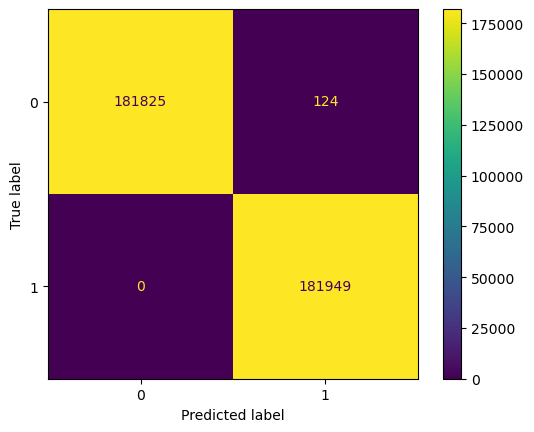

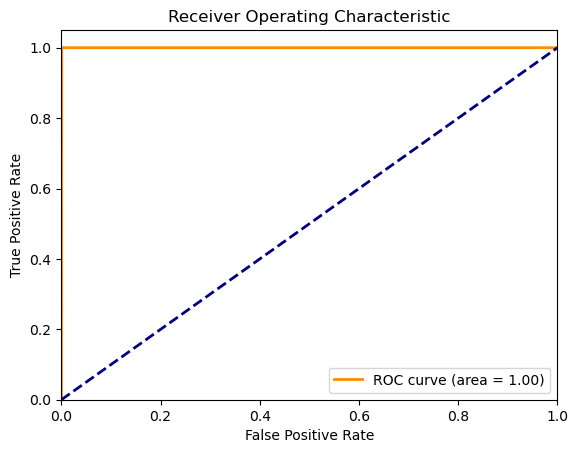

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, roc_curve, auc, f1_score

y_pred = neo_reg.predict(x_test)

accuracy_score_value  = accuracy_score(y_test, y_pred)
print('Accuracy Score: ', accuracy_score_value )

cv_scores = cross_val_score(neo_reg, x_train, y_train, cv=5)
print('Cross Validation Accuracy: ', cv_scores.mean())

print(classification_report(y_test, y_pred))

# Precision and recall scores
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print('Precision: ', precision)
print('Recall: ', recall)

# f1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print('F1 Score: ', f1)

cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix: \n', cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot()


# Plot AUC-ROC curve
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
roc_auc = auc(fpr, tpr)
print("\nAUC-ROC Score: {:.6f}".format(roc_auc))

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


#### Neural Network

In [3]:
import tensorflow as tf

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
    # Additional information about the GPU
    physical_devices = tf.config.list_physical_devices('GPU')
    print("Details of GPU:", physical_devices)
else:
    print("GPU is NOT available")

GPU is available
Details of GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.metrics import Precision, Recall
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.callbacks import EarlyStopping, CSVLogger
from sklearn.preprocessing import StandardScaler

tf.random.set_seed(42)
np.random.seed(42)

# Get the dataset
x_train, x_test, y_train, y_test = get_data()
print("Got data", end="\n\n")

# Detecting the number of input features
num_input_features = x_train.shape[1]

# Building the ANN model
model = Sequential([
    Dense(64, activation='relu', input_shape=(num_input_features,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compiling the model
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Defining early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Defining CSV Logger callback
os.makedirs('Asteroid-Risk-Classification\Performance_Logs', exist_ok=True)
csv_logger = CSVLogger('Asteroid-Risk-Classification\Performance_Logs\\ac_dataset_neo_pha_logs.csv', separator=",", append=True)

# Training the model
history = model.fit(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping, csv_logger], workers=4, use_multiprocessing=True, verbose=1, batch_size=128, shuffle=True)


Got data

Epoch 1/100
9094/9094 [==============================] - 45s 5ms/step - loss: 0.0072 - accuracy: 0.9978 - precision: 0.9955 - recall: 0.9986 - val_loss: 0.0086 - val_accuracy: 0.9973 - val_precision: 1.0000 - val_recall: 0.9973
Epoch 2/100
9094/9094 [==============================] - 36s 4ms/step - loss: 0.0018 - accuracy: 0.9994 - precision: 0.9988 - recall: 0.9997 - val_loss: 5.6939e-04 - val_accuracy: 0.9998 - val_precision: 1.0000 - val_recall: 0.9998
Epoch 3/100
9094/9094 [==============================] - 39s 4ms/step - loss: 0.0015 - accuracy: 0.9995 - precision: 0.9990 - recall: 0.9997 - val_loss: 0.0032 - val_accuracy: 0.9996 - val_precision: 1.0000 - val_recall: 0.9996
Epoch 4/100
9094/9094 [==============================] - 37s 4ms/step - loss: 0.0014 - accuracy: 0.9996 - precision: 0.9991 - recall: 0.9997 - val_loss: 2.4205e-04 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/100
9094/9094 [==============================] - 41s 5ms/step 

In [6]:
import numpy as np

# Evaluating the model on test data
y_pred_prob = model.predict(x_test)  # Predict probabilities
y_pred = np.where(y_pred_prob > 0.5, 1, 0)  # Convert probabilities to class labels using threshold

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)


11372/11372 [==============================] - 10s 891us/step
Test Accuracy: 0.9998241265409538
Test Precision: 0.9998241265409538
Test Recall: 0.9998241265409538
Test F1 Score: 0.9998241265409538


In [12]:
# Save tensorflow model
path = "models"
model.save_weights(os.path.join(path, 'ac_dataset_neo_pha_model.h5'))

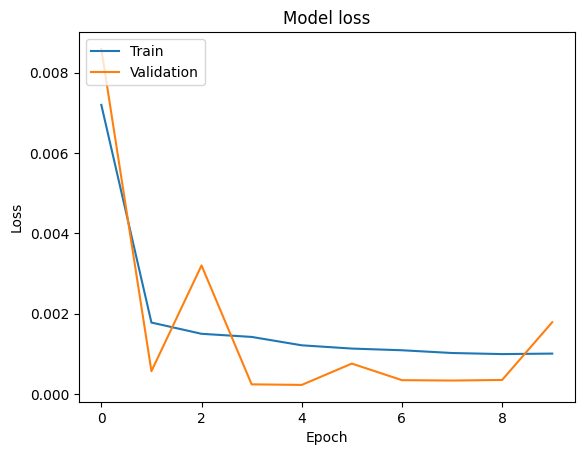

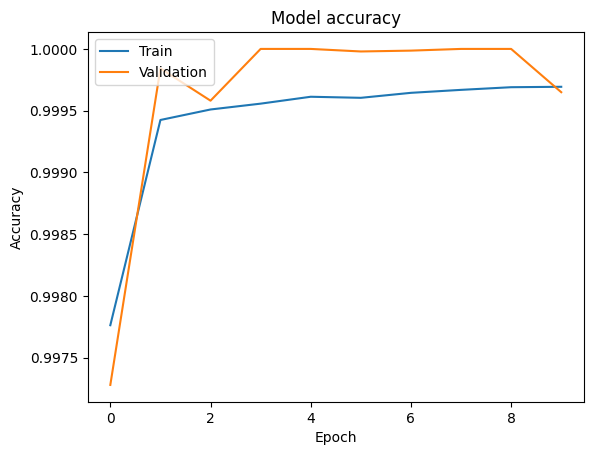

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
tf.debugging.set_log_device_placement(False)

### Potential Hazard Classification

#### Dataset

In [12]:
x = df1.iloc[:, :-4]
y = df1.iloc[:, -1]

temp = pd.concat([x, y], axis=1)
correlation_with_neo = temp.corr()['pha']
top_attributes = correlation_with_neo.abs().nlargest(11).index
temp = temp[top_attributes]

x = temp.iloc[:, 1:]
y = temp.iloc[:, 0]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

smote = SMOTE()
x_train, y_train = smote.fit_resample(x_train, y_train)
x_test, y_test = smote.fit_resample(x_test, y_test)

#### Logistic Regression

In [16]:
pha_reg = LogisticRegression(max_iter=10000, random_state=0, n_jobs=-1)
pha_reg.fit(x_train, y_train)

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=0)

Accuracy Score:  0.9973156706792777
Cross Validation Accuracy:  0.9973138546932174
Confusion Matrix: 
 [[185081    999]
 [     0 186080]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    186080
           1       0.99      1.00      1.00    186080

    accuracy                           1.00    372160
   macro avg       1.00      1.00      1.00    372160
weighted avg       1.00      1.00      1.00    372160

Precision:  0.9973300049711619
Recall:  0.9973156706792777
F1 Score:  0.9973156513368707

AUC-ROC Score: 0.997316


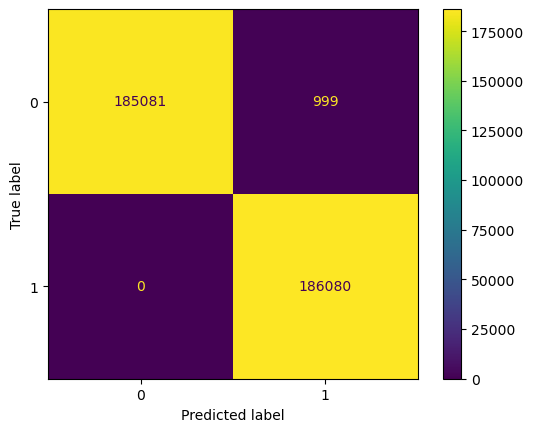

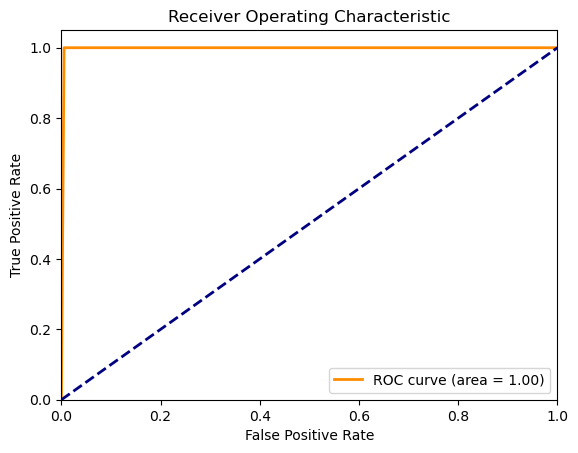

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, roc_curve, auc, f1_score

y_pred = pha_reg.predict(x_test)

accuracy_score_value  = accuracy_score(y_test, y_pred)
print('Accuracy Score: ', accuracy_score_value )

cv_scores = cross_val_score(pha_reg, x_train, y_train, cv=5)
print('Cross Validation Accuracy: ', cv_scores.mean())

cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix: \n', cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot()

print(classification_report(y_test, y_pred))

# Precision and recall scores
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print('Precision: ', precision)
print('Recall: ', recall)

# F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print('F1 Score: ', f1)

# Plot AUC-ROC curve
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
roc_auc = auc(fpr, tpr)
print("\nAUC-ROC Score: {:.6f}".format(roc_auc))

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


#### Neural Network

In [18]:
# joblib.dump(neo_reg, 'models/neo_reg_0.joblib')
# joblib.dump(pha_reg, 'models/pha_reg_0.joblib')

## Next Dataset

### Hazard Classification

#### Dataset

In [19]:
df = pd.read_csv('datasets/ab_cneos_closeapproach_data_pha.csv', engine='pyarrow')

In [20]:
x = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [21]:
# test_1 = pd.concat([x.iloc[:20, :], y[:20]], axis=1)
# test_1.to_csv('Front-End/resources/test2.csv', index=False)

In [22]:
import re

def extract_upper_limit(value):
    if not 'km' in value:
        # Extract the upper limit from "X m - Y m" or "X m" format
        limits = re.findall(r'[\d.]+', value)
        if limits:
            return float(limits[-1])
    return value

# Assuming x['Diameter (m)'] is your column
x['Diameter'] = x['Diameter'].apply(extract_upper_limit)


In [23]:
print(x['Diameter'].head())

0           550.0
1            82.0
2            77.0
3    0.33±0.05 km
4            90.0
Name: Diameter, dtype: object


In [24]:
x = x[x['Diameter'].apply(lambda x: 'km' not in str(x))]
print(x['Diameter'].head())

0    550.0
1     82.0
2     77.0
4     90.0
5     57.0
Name: Diameter, dtype: object


In [25]:
x.drop(['Object'], axis=1, inplace=True)

In [26]:
print(x.info())

<class 'pandas.core.frame.DataFrame'>
Index: 33892 entries, 0 to 35909
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Close-Approach (CA) Date  33892 non-null  object 
 1   CA DistanceNominal (au)   33892 non-null  object 
 2   CA DistanceMinimum (au)   33892 non-null  float64
 3   V relative(km/s)          33892 non-null  float64
 4   V infinity(km/s)          33892 non-null  object 
 5   H(mag)                    33892 non-null  float64
 6   Diameter                  33892 non-null  object 
dtypes: float64(3), object(4)
memory usage: 2.1+ MB
None


In [27]:
final = pd.concat([x, y], axis=1)

final.dropna(inplace=True)

In [28]:
print(final.info())

<class 'pandas.core.frame.DataFrame'>
Index: 33892 entries, 0 to 35909
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Close-Approach (CA) Date  33892 non-null  object 
 1   CA DistanceNominal (au)   33892 non-null  object 
 2   CA DistanceMinimum (au)   33892 non-null  float64
 3   V relative(km/s)          33892 non-null  float64
 4   V infinity(km/s)          33892 non-null  object 
 5   H(mag)                    33892 non-null  float64
 6   Diameter                  33892 non-null  object 
 7   pha                       33892 non-null  int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 2.3+ MB
None


In [29]:
x = final.iloc[:, :-1]
y = final.iloc[:, -1]

In [30]:
# Assuming df is your DataFrame and 'Diameter (m)' is the column
x['Diameter'] = x['Diameter'].astype(float)


In [31]:
def clean_and_convert(value):
    # Extract numeric part using regex
    numeric_part = re.search(r'[\d.]+', str(value))
    if numeric_part:
        return float(numeric_part.group())
    else:
        return None  # or handle non-convertible values as needed

# Assuming x is your DataFrame and 'CA DistanceNominal (au)' is the column
x['CA DistanceNominal (au)'] = x['CA DistanceNominal (au)'].apply(clean_and_convert)

In [32]:
# Assuming x is your DataFrame and 'V infinity(km/s)' is the column
x['V infinity(km/s)'] = pd.to_numeric(x['V infinity(km/s)'], errors='coerce').fillna(0).astype(float)


In [33]:
x.drop('Close-Approach (CA) Date', axis=1, inplace=True)

In [34]:
print(x.info(), y.info())

<class 'pandas.core.frame.DataFrame'>
Index: 33892 entries, 0 to 35909
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CA DistanceNominal (au)  33892 non-null  float64
 1   CA DistanceMinimum (au)  33892 non-null  float64
 2   V relative(km/s)         33892 non-null  float64
 3   V infinity(km/s)         33892 non-null  float64
 4   H(mag)                   33892 non-null  float64
 5   Diameter                 33892 non-null  float64
dtypes: float64(6)
memory usage: 1.8 MB
<class 'pandas.core.series.Series'>
Index: 33892 entries, 0 to 35909
Series name: pha
Non-Null Count  Dtype
--------------  -----
33892 non-null  int64
dtypes: int64(1)
memory usage: 529.6 KB
None None


In [35]:
# train1 = pd.concat([x.iloc[:20, :], y[:20]], axis=1)
# train1.to_csv('Front-End/resources/test2.csv', index=False)

In [36]:
# train1 = pd.concat([x, y], axis=1)
# train1.to_csv('Front-End/resources/train2.csv', index=False)

In [37]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

# smote = SMOTE()
# x_train, y_train = smote.fit_resample(x_train, y_train)

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

smote = SMOTE()
x_train, y_train = smote.fit_resample(x_train, y_train)
x_test, y_test = smote.fit_resample(x_test, y_test)

In [39]:
hazard_reg = LogisticRegression(max_iter=10000, random_state=0, n_jobs=4)
hazard_reg.fit(x_train, y_train)

LogisticRegression(max_iter=10000, n_jobs=4, random_state=0)

Accuracy Score:  0.9415510575392313
Cross Validation Accuracy:  0.9482960428617735
Confusion Matrix: 
 [[4057  340]
 [ 174 4223]]
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      4397
           1       0.93      0.96      0.94      4397

    accuracy                           0.94      8794
   macro avg       0.94      0.94      0.94      8794
weighted avg       0.94      0.94      0.94      8794

Precision:  0.9421812941257334
Recall:  0.9415510575392313
F1 Score:  0.9415302234419499

AUC-ROC Score: 0.941551


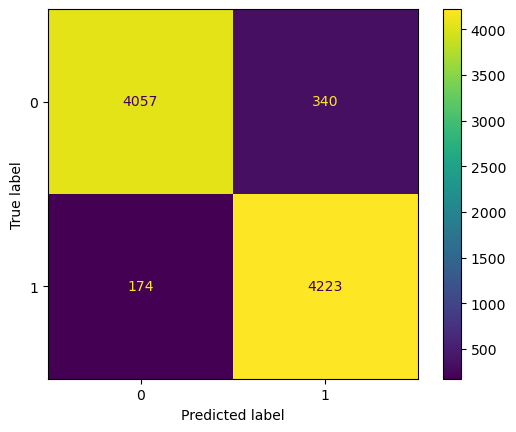

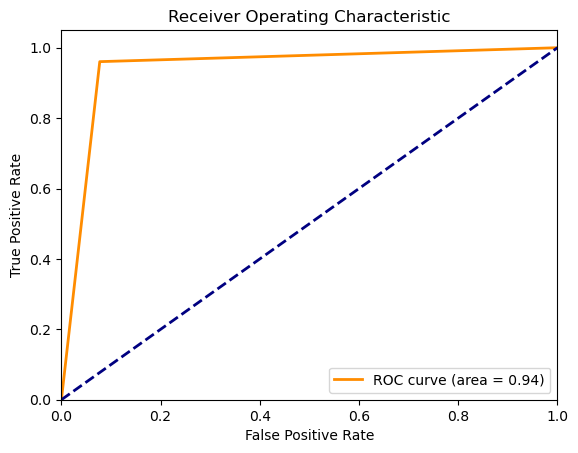

In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, roc_curve, auc, f1_score

y_pred = hazard_reg.predict(x_test)

accuracy_score_value  = accuracy_score(y_test, y_pred)
print('Accuracy Score: ', accuracy_score_value )

cv_scores = cross_val_score(hazard_reg, x_train, y_train, cv=5)
print('Cross Validation Accuracy: ', cv_scores.mean())

cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix: \n', cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot()

print(classification_report(y_test, y_pred))

# Precision and recall scores
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print('Precision: ', precision)
print('Recall: ', recall)

# F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print('F1 Score: ', f1)

# Plot AUC-ROC curve
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
roc_auc = auc(fpr, tpr)
print("\nAUC-ROC Score: {:.6f}".format(roc_auc))

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [41]:
# joblib.dump(hazard_reg, 'models/pha_reg_1.joblib')